In [1]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow as tf

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

#train_dataset =  train_dataset.cache()
#test_dataset  =  test_dataset.cache()

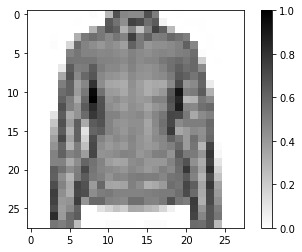

In [5]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

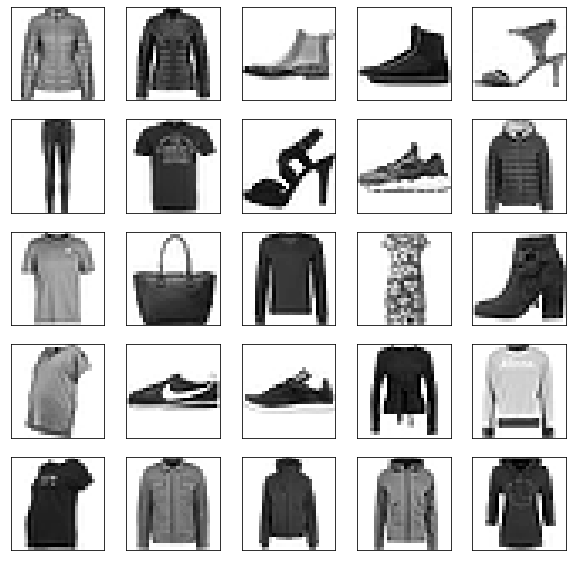

In [6]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    i += 1
plt.show()

In [7]:
BATCH_SIZE = 128
train_dataset = train_dataset.cache().repeat().shuffle(60000).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [8]:
print (train_dataset)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dense(1024, activation='tanh'),
    tf.keras.layers.Dense(2048, activation='tanh'),
    tf.keras.layers.Dense(1024, activation='tanh'),
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(10)])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
hist = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(60000/BATCH_SIZE))

Epoch 1/10
469/469 [==============================] - 28s 48ms/step - loss: 0.6235 - accuracy: 0.7837
Epoch 2/10
469/469 [==============================] - 22s 48ms/step - loss: 0.4611 - accuracy: 0.8372
Epoch 3/10
469/469 [==============================] - 22s 47ms/step - loss: 0.4131 - accuracy: 0.8525
Epoch 4/10
469/469 [==============================] - 22s 48ms/step - loss: 0.3882 - accuracy: 0.8603
Epoch 5/10
469/469 [==============================] - 22s 47ms/step - loss: 0.3721 - accuracy: 0.8640
Epoch 6/10
469/469 [==============================] - 22s 48ms/step - loss: 0.3657 - accuracy: 0.8670
Epoch 7/10
469/469 [==============================] - 22s 47ms/step - loss: 0.3527 - accuracy: 0.8739
Epoch 8/10
469/469 [==============================] - 23s 48ms/step - loss: 0.3386 - accuracy: 0.8767
Epoch 9/10
469/469 [==============================] - 23s 48ms/step - loss: 0.3333 - accuracy: 0.8779
Epoch 10/10
469/469 [==============================] - 23s 48ms/step - loss: 0.320

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(10000/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

79/79 [==============================] - 2s 21ms/step - loss: 0.3831 - accuracy: 0.8638
Accuracy on test dataset: 0.8637999892234802


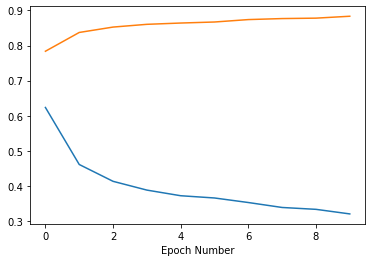

In [13]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.plot(hist.history['loss']);
plt.plot(hist.history['accuracy']);

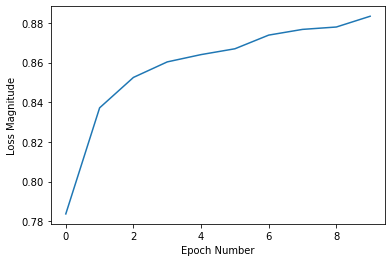

In [14]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(hist.history['accuracy']);

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpr1ot7hsy/assets
INFO:tensorflow:Assets written to: /tmp/tmpr1ot7hsy/assets


In [16]:
tflite_model_file = "mnist_model.tflite"
open(tflite_model_file, 'wb').write(tflite_model)

21966936

In [17]:
pred = model.predict(test_dataset)
print(pred)
pred_cat = tf.argmax(pred, axis=1)
true_cat = tf.concat([y for x, y in test_dataset], axis=0)
tf.math.confusion_matrix(true_cat,pred_cat)

[[-1.1673048  -1.8792937   3.389777   ... -1.3561774  -0.76906925
  -2.8706777 ]
 [-1.1785569  -2.1562815   3.3273125  ... -1.5781368  -0.7961773
  -3.010804  ]
 [-3.8070402  -2.9173315  -1.0153018  ...  2.9228902   0.10110204
   7.039257  ]
 ...
 [ 1.8741268   2.9000356   2.2541027  ... -2.803394   -0.52274984
  -7.1174307 ]
 [-0.5766026  -2.741953    2.33436    ... -2.6566205  -0.13035001
  -2.4905455 ]
 [-0.30163467 10.080817    0.17465869 ... -0.07181817 -2.0812087
  -0.5999573 ]]


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[835,   1,  17,  94,   4,   0,  37,   0,  12,   0],
       [  3, 956,   1,  33,   3,   0,   2,   0,   2,   0],
       [ 15,   1, 850,  25,  60,   0,  44,   0,   5,   0],
       [ 19,   6,   9, 927,  28,   0,   7,   0,   4,   0],
       [  0,   1, 187,  44, 741,   0,  25,   0,   2,   0],
       [  0,   0,   0,   1,   0, 947,   0,  30,   1,  21],
       [172,   0, 112,  94, 100,   0, 510,   0,  12,   0],
       [  0,   0,   0,   0,   0,  22,   0, 958,   0,  20],
       [  3,   0,   4,  10,   4,   2,   0,   5, 972,   0],
       [  0,   0,   0,   0,   0,  11,   1,  46,   0, 942]], dtype=int32)>